In [1]:
# STEP 1: Upload service account key
from google.colab import files
uploaded = files.upload()

# STEP 2: Set environment and download from GCS
import os
json_filename = list(uploaded.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_filename
print(f"Using service account: {json_filename}")

# STEP 3: Download Onion dataset from GCS
GCS_URI = "gs://onion11"
!mkdir -p OnionData
!gsutil -m cp -r {GCS_URI}/* OnionData/

Streaming output truncated to the last 5000 lines.
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0582_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.JPG...
Copying gs://onion11/BR_E5_P3_S_0583_FEB_7.txt...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0694__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.JPG...
Copying gs://onion11/BR_E5_P3_S_0695__FEB_8.txt...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0735_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.JPG...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0736_FEB_9.txt...
Copying gs://onion11/BR_E5_P3_S_0787__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0788__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.JPG...
Copying gs://onion11/BR_E5_P3_S_0832__FEB_14.txt...
Copying gs://onion11/BR_E5_P3_S_0

In [2]:
# STEP 4: Prepare dataset
import shutil
import random

base_dir = 'OnionData'
class_id_to_name = {}
classes_txt_path = os.path.join(base_dir, 'classes.txt')

if os.path.exists(classes_txt_path):
    with open(classes_txt_path, 'r') as f:
        for i, line in enumerate(f):
            class_id_to_name[str(i)] = line.strip()

jpgs = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.jpg')}
txts = {os.path.splitext(f)[0]: f for f in os.listdir(base_dir) if f.endswith('.txt')}
paired = [base for base in jpgs if base in txts]

class_to_images = {}
for base in paired:
    with open(os.path.join(base_dir, txts[base]), 'r') as f:
        line = f.readline().strip()
        if line:
            class_id = line.split()[0]
            label = class_id_to_name.get(class_id, f"class_{class_id}")
            class_to_images.setdefault(label, []).append(jpgs[base])

for split in ['train', 'val', 'test']:
    shutil.rmtree(split, ignore_errors=True)
    for label in class_to_images:
        os.makedirs(os.path.join(split, label), exist_ok=True)

for label, images in class_to_images.items():
    random.shuffle(images)
    n = len(images)
    train_n, val_n = int(0.8*n), int(0.1*n)
    for img in images[:train_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('train', label, img))
    for img in images[train_n:train_n+val_n]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('val', label, img))
    for img in images[train_n+val_n:]:
        shutil.copy(os.path.join(base_dir, img), os.path.join('test', label, img))

In [3]:
# STEP 5: Data loading
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_loader = train_gen.flow_from_directory('train', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_loader = val_gen.flow_from_directory('val', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_loader = test_gen.flow_from_directory('test', target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

print("Detected classes:", train_loader.class_indices)

Found 866 images belonging to 6 classes.
Found 106 images belonging to 6 classes.
Found 113 images belonging to 6 classes.
Detected classes: {'Anthracnose': 0, 'Basal_Rot': 1, 'Iris_Yellow_Spot_Virus': 2, 'Purple_Blotch': 3, 'Stemphylium_Blight': 4, 'Thrips': 5}


In [4]:
# STEP 6: DenseNet121 model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(train_loader.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,565,382 (28.86 MB)

 Trainable params: 527,878 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [5]:
# STEP 7: Train the model
import time
EPOCHS = 10
start_time = time.time()

history = model.fit(train_loader, validation_data=val_loader, epochs=EPOCHS)
training_time = time.time() - start_time

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.5733 - loss: 1.1744 - val_accuracy: 0.8208 - val_loss: 0.5112
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.7736 - loss: 0.5928 - val_accuracy: 0.8113 - val_loss: 0.4147
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8292 - loss: 0.4403 - val_accuracy: 0.8585 - val_loss: 0.3760
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.8304 - loss: 0.4434 - val_accuracy: 0.8302 - val_loss: 0.3609
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.8570 - loss: 0.3784 - val_accuracy: 0.8491 - val_loss: 0.3408
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.8448 - loss: 0.3499 - val_accuracy: 0.8491 - val_loss: 0.3075
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.9119 - loss: 0.2847 - val_accuracy: 0.8585 - val_loss: 0.3291
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.8668 - loss: 0.3190 - val_accuracy: 0.8302 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.8440 - loss: 0.4621


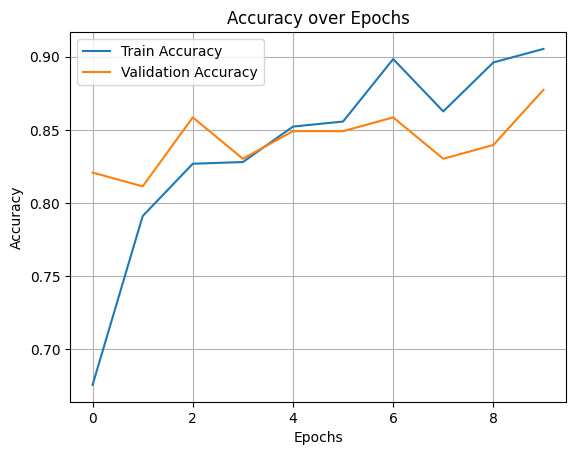

In [6]:
# STEP 8: Evaluate model
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(test_loader)

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step

📊 Classification Report:
                        precision    recall  f1-score   support

           Anthracnose       0.19      0.16      0.18        31
             Basal_Rot       0.00      0.00      0.00         2
Iris_Yellow_Spot_Virus       0.19      0.20      0.19        25
         Purple_Blotch       0.09      0.10      0.10        10
    Stemphylium_Blight       0.15      0.20      0.17        15
                Thrips       0.45      0.43      0.44        30

              accuracy                           0.24       113
             macro avg       0.18      0.18      0.18       113
          weighted avg       0.24      0.24      0.24       113



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


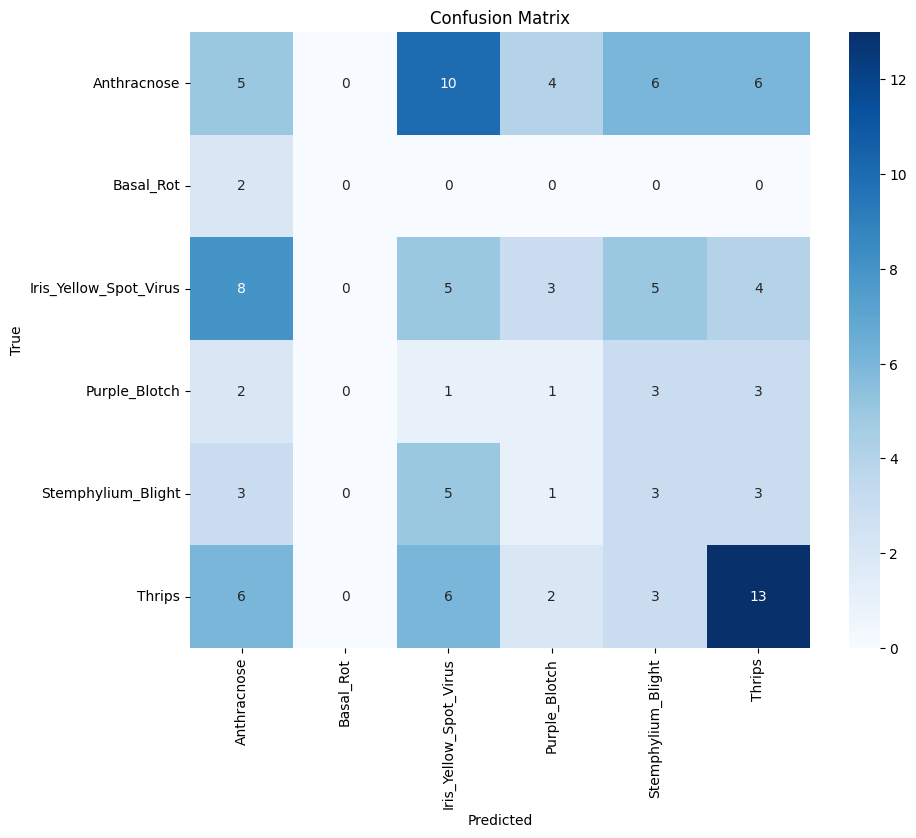

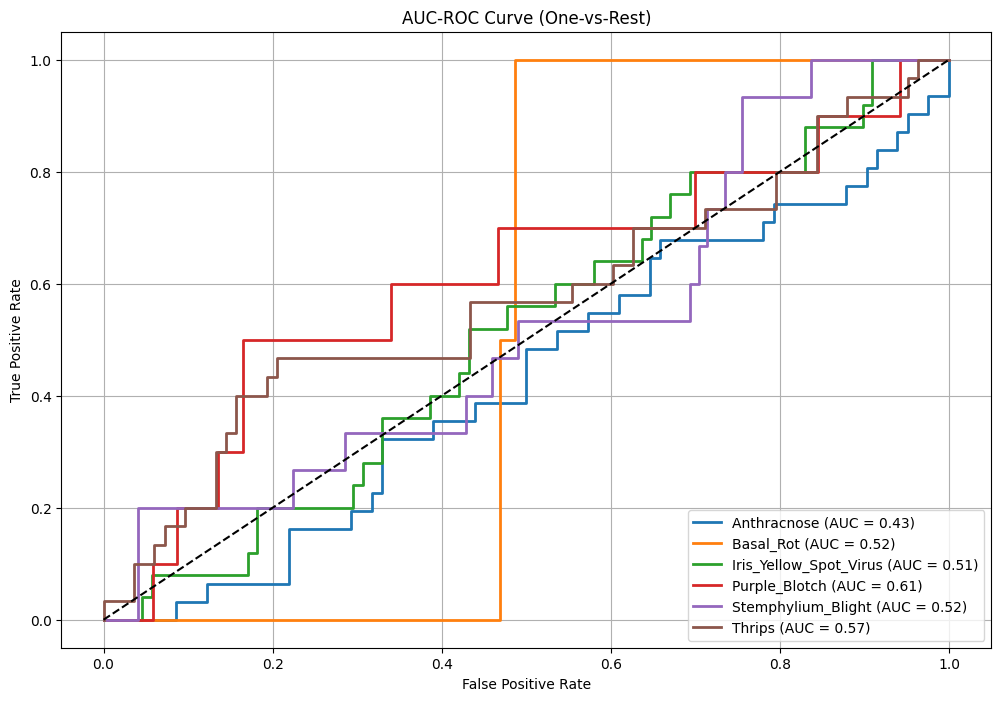

In [7]:
# STEP 9: Classification report, Confusion matrix, AUC
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

y_pred = model.predict(test_loader)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_loader.classes
class_labels = list(test_loader.class_indices.keys())

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC
y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

plt.figure(figsize=(12, 8))
for i, label in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve (One-vs-Rest)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [8]:
# STEP 10: Final metrics summary
model_size_MB = sum([np.prod(v.shape) for v in model.trainable_variables]) * 4 / (1024 ** 2)

print(f"\n✅ Training Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"✅ Validation Accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"⏱️ Training Time: {training_time:.2f} seconds")
print(f"📦 Model Size: {model_size_MB:.2f} MB")
print(f"🧮 Macro-average AUC: {roc_auc_score(y_true_bin, y_pred, average='macro'):.4f}")
print(f"🧮 Weighted-average AUC: {roc_auc_score(y_true_bin, y_pred, average='weighted'):.4f}")


✅ Training Accuracy: 90.53%
✅ Validation Accuracy: 87.74%
✅ Test Accuracy: 84.96%
⏱️ Training Time: 1065.46 seconds
📦 Model Size: 2.01 MB
🧮 Macro-average AUC: 0.5279
🧮 Weighted-average AUC: 0.5156
